### applying decision tree to determine important characteristics of the difference between MC signal thats good and MC signal that doesnt get caught.

- load in MC
- collect signal and dead-signal copy
- separate MC into signal and background
- apply classifier (BDT or normal decision tree)
- get the importance out

In [1]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
import core.functions as func
#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook


#%matplotlib widget
#import ipympl

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from tqdm import tqdm

# MACHINE LEARNING IMPORTS
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


pd.set_option('display.max_rows', 500)

In [2]:
def collect_signal_events(folder_path, event_numbers):

    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
    
    i = 0

    for file in tqdm(file_names):

        file_path = folder_path + file
        df = dstio.load_dst(file_path, 'DECO', 'Events')
        if (i == 0):
            signal_df = df[df['event'].isin(event_numbers)]
            i += 1
        else:
            signal_df = signal_df.append(df[df['event'].isin(event_numbers)], ignore_index = True)
        
    return signal_df
            

def collect_signal_events_MC(folder_path, event_numbers):

    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
    
    i = 0

    for file in tqdm(file_names):

        file_path = folder_path + file
        df = mcio.load_mchits_df(file_path).reset_index()
        if (i == 0):
            signal_df = df[df['event_id'].isin(event_numbers)]
            i += 1
        else:
            signal_df = signal_df.append(df[df['event_id'].isin(event_numbers)], ignore_index = True)
        
    return signal_df

#### loading in MC signal and lost signal events

In [3]:
MC_signals = np.load('port_1a_signal_evts.npy')
MC_signals = np.array(MC_signals)
MC_lost = np.load('port_1a_isaura_lost_evts.npy')
MC_lost = np.array(MC_lost)

In [4]:
# loading in the MC
i =0
folder_path = 'testing_data/beersheba/'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
df_trs = []

for file in file_names:
    file_path = folder_path + file
    MC_file = pd.read_hdf(file_path, 'MC/particles')
    df_trs.append(MC_file)
    i += 1

    if (i%50 == 0):
        print(i)
df_trs = pd.concat(df_trs, axis = 0, ignore_index = True)


50
100
150
200
250
300


In [5]:
# create subsections of lost and saved particles
lost_df = df_trs[df_trs.event_id.isin(np.array(MC_lost))]
lost_df['tag'] = 'lost'
signal_df = df_trs[df_trs.event_id.isin(np.array(MC_signals))]
signal_df['tag'] = 'sig'
display(lost_df)
display(signal_df)


/tmp/ipykernel_24623/4167569056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lost_df['tag'] = 'lost'
/tmp/ipykernel_24623/4167569056.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal_df['tag'] = 'sig'


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,tag
9016,2040116,1,Tl208,True,0,394.018707,395.126160,537.897034,0.000000,394.018707,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,none,RadioactiveDecay,lost
9017,2040116,4,e-,False,1,394.018707,395.126160,537.897034,0.000044,400.812225,...,0.496121,0.188790,-0.000000,0.000000,-0.000000,0.408026,2.384524e+01,RadioactiveDecay,eIoni,lost
9018,2040116,3,anti_nu_e,False,1,394.018707,395.126160,537.897034,0.000044,-3391.741455,...,0.729038,-0.441749,-0.228004,0.729038,-0.441749,0.882398,1.465123e+04,RadioactiveDecay,Transportation,lost
9019,2040116,2,Pb208[3708.451],False,1,394.018707,395.126160,537.897034,0.000044,394.018707,...,-1.225157,0.252959,0.000000,-0.000000,0.000000,0.000006,0.000000e+00,RadioactiveDecay,RadioactiveDecay,lost
9020,2040116,6,gamma,False,2,394.018707,395.126160,537.897034,0.000044,-232.659363,...,-0.397561,0.131886,0.000000,-0.000000,0.000000,0.510739,1.097046e+03,RadioactiveDecay,phot,lost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8000948,280184,57,e-,False,53,810.145386,710.037659,642.140259,1.771267,810.145386,...,0.004929,-0.003303,0.000000,-0.000000,0.000000,0.000035,6.392543e-07,compt,msc,lost
8000949,280184,56,e-,False,53,810.145386,710.037659,642.140259,1.771267,810.145386,...,-0.007107,-0.009238,-0.000000,-0.000000,0.000000,0.000173,5.095803e-06,compt,eIoni,lost
8000950,280184,55,e-,False,53,810.145386,710.037659,642.140259,1.771267,810.145386,...,-0.032930,0.038089,0.000000,-0.000000,0.000000,0.002640,9.145194e-05,compt,eIoni,lost
8000951,280184,54,e-,False,53,810.145386,710.037659,642.140259,1.771267,810.109192,...,0.089707,0.600202,-0.000000,0.000000,-0.000000,1.006380,7.016248e-01,compt,eIoni,lost


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,tag
192,2040002,1,Tl208,True,0,398.217529,397.111115,531.619568,0.000000,398.217529,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,none,RadioactiveDecay,sig
193,2040002,4,e-,False,1,398.217529,397.111115,531.619568,0.002894,395.140350,...,0.160702,0.213252,-0.000000,0.00000,-0.000000,0.081268,6.252266,RadioactiveDecay,eIoni,sig
194,2040002,3,anti_nu_e,False,1,398.217529,397.111115,531.619568,0.002894,-981.225342,...,0.080840,1.198516,-0.138138,0.08084,1.198516,1.209156,12074.628906,RadioactiveDecay,Transportation,sig
195,2040002,2,Pb208[3708.451],False,1,398.217529,397.111115,531.619568,0.002894,398.217529,...,-0.241541,-1.411767,0.000000,-0.00000,-0.000000,0.000005,0.000000,RadioactiveDecay,RadioactiveDecay,sig
196,2040002,6,gamma,False,2,398.217529,397.111115,531.619568,0.002894,180.341843,...,-0.370351,0.210789,-0.000000,0.00000,0.000000,0.510739,326.817322,RadioactiveDecay,phot,sig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8039416,1310327,86,e-,False,82,195.094009,264.369080,358.266876,1.217881,195.094162,...,0.001020,0.003891,-0.000000,0.00000,-0.000000,0.000044,0.000196,phot,msc,sig
8039417,1310327,85,e-,False,82,195.094009,264.369080,358.266876,1.217881,195.093964,...,0.003354,0.005582,-0.000000,0.00000,-0.000000,0.000046,0.000124,phot,msc,sig
8039418,1310327,84,e-,False,82,195.094009,264.369080,358.266876,1.217881,195.093735,...,-0.014804,-0.017400,-0.000000,-0.00000,0.000000,0.000542,0.002890,phot,eIoni,sig
8039419,1310327,83,e-,False,82,195.094009,264.369080,358.266876,1.217881,195.095123,...,0.002133,-0.039169,-0.000000,-0.00000,0.000000,0.001765,0.012114,phot,eIoni,sig


In [6]:
# quick check, see how many event_ids have an e+ event
# should be as many as there are unique event ids
print(len(np.unique(signal_df.event_id.values)))
print(len(signal_df[signal_df.particle_name == 'e+'].index))

for event, df in signal_df.groupby("event_id"):
    a = df['particle_name'].value_counts()
    if a['e+'] > 1:
        print("EVENT WITH TWO POSITRONS: {}".format(event))
    elif a['e+'] < 1:
        print("EVENT WITH NO POSITRONS: {}".format(event))


6939
6941
EVENT WITH TWO POSITRONS: 470240
EVENT WITH TWO POSITRONS: 1680314


In [19]:
display(signal_df[signal_df.event_id == 470240])
display(signal_df[signal_df.event_id == 1680314])

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,tag
7331629,470240,1,Tl208,True,0,397.537292,393.040161,532.048523,0.000000,397.537292,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000e+00,0.000000e+00,none,RadioactiveDecay,sig
7331630,470240,4,e-,False,1,397.537292,393.040161,532.048523,0.000844,397.777588,...,-0.422475,0.489742,0.00000,0.000000,-0.00000,3.263909e-01,1.160193e+00,RadioactiveDecay,eIoni,sig
7331631,470240,3,anti_nu_e,False,1,397.537292,393.040161,532.048523,0.000844,-9628.555664,...,1.133825,0.088160,-0.93895,1.133825,0.08816,1.474774e+00,1.574761e+04,RadioactiveDecay,Transportation,sig
7331632,470240,2,Pb208[3197.711],False,1,397.537292,393.040161,532.048523,0.000844,397.537292,...,-0.711350,-0.577902,0.00000,-0.000000,-0.00000,3.785186e-06,0.000000e+00,RadioactiveDecay,RadioactiveDecay,sig
7331633,470240,6,gamma,False,2,397.537292,393.040161,532.048523,0.000844,410.896606,...,0.345440,-0.118540,-0.00000,0.000000,0.00000,5.831881e-01,4.415917e+01,RadioactiveDecay,phot,sig
7331634,470240,23,e-,False,6,410.896606,401.914581,517.955872,0.148144,410.896606,...,0.007176,-0.002938,-0.00000,0.000000,-0.00000,6.090000e-05,1.475862e-07,phot,msc,sig
7331635,470240,22,e-,False,6,410.896606,401.914581,517.955872,0.148144,410.896606,...,-0.002199,0.005634,-0.00000,-0.000000,0.00000,5.826000e-05,1.450558e-07,phot,msc,sig
7331636,470240,21,e-,False,6,410.896606,401.914581,517.955872,0.148144,410.896606,...,-0.004698,0.002245,0.00000,-0.000000,0.00000,3.096000e-05,1.181998e-07,phot,msc,sig
7331637,470240,20,e-,False,6,410.896606,401.914581,517.955872,0.148144,410.896606,...,-0.024827,-0.003120,0.00000,-0.000000,-0.00000,7.383700e-04,1.276327e-05,phot,eIoni,sig
7331638,470240,19,gamma,False,6,410.896606,401.914581,517.955872,0.148144,410.899994,...,0.007438,-0.001167,0.00000,0.000000,-0.00000,8.005710e-03,9.990021e-03,phot,phot,sig


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,tag
3994364,1680314,1,Tl208,True,0,396.948456,397.100769,531.499451,0.000000,396.948456,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,none,RadioactiveDecay,sig
3994365,1680314,4,e-,False,1,396.948456,397.100769,531.499451,0.002339,402.451477,...,-0.065342,0.465547,-0.000000,0.000000,-0.000000,5.928121e-01,6.577666e+00,RadioactiveDecay,eIoni,sig
3994366,1680314,3,anti_nu_e,False,1,396.948456,397.100769,531.499451,0.002339,-3766.957520,...,-1.093192,0.374799,-0.352944,-1.093192,0.374799,1.208351e+00,1.425571e+04,RadioactiveDecay,Transportation,sig
3994367,1680314,2,Pb208[3197.711],False,1,396.948456,397.100769,531.499451,0.002339,396.948456,...,1.158534,-0.840346,-0.000000,0.000000,-0.000000,5.946407e-06,0.000000e+00,RadioactiveDecay,RadioactiveDecay,sig
3994368,1680314,6,gamma,False,2,396.948456,397.100769,531.499451,0.002339,407.013458,...,0.430558,0.338684,0.000000,-0.000000,-0.000000,5.831881e-01,5.194136e+01,RadioactiveDecay,phot,sig
3994369,1680314,19,e-,False,6,407.013458,395.520844,547.782227,0.175596,407.013458,...,-0.007367,-0.001206,0.000000,-0.000000,0.000000,5.797000e-05,1.447787e-07,phot,msc,sig
3994370,1680314,18,e-,False,6,407.013458,395.520844,547.782227,0.175596,407.013458,...,-0.000677,-0.006437,0.000000,-0.000000,0.000000,5.826000e-05,1.450558e-07,phot,msc,sig
3994371,1680314,17,e-,False,6,407.013458,395.520844,547.782227,0.175596,407.013458,...,-0.002249,0.006158,-0.000000,0.000000,-0.000000,5.826000e-05,1.450558e-07,phot,msc,sig
3994372,1680314,16,e-,False,6,407.013458,395.520844,547.782227,0.175596,407.013458,...,-0.013386,-0.017089,0.000000,-0.000000,-0.000000,9.178900e-04,1.639250e-05,phot,eIoni,sig
3994373,1680314,15,e-,False,6,407.013458,395.520844,547.782227,0.175596,407.013458,...,-0.020103,-0.005768,0.000000,-0.000000,0.000000,7.817700e-04,1.304031e-05,phot,eIoni,sig


In [33]:

display(lost_df)
# drop a bunch of the signal, its too much!
signal_df.drop(signal_df.tail(545400).index, inplace = True)
display(signal_df)
# then remove the elements that have half an event within them
signal_df = signal_df[signal_df.event_id != 840146]
display(signal_df)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,tag
9016,2040116,1,Tl208,True,0,394.018707,395.126160,537.897034,0.000000,394.018707,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,none,RadioactiveDecay,lost
9017,2040116,4,e-,False,1,394.018707,395.126160,537.897034,0.000044,400.812225,...,0.496121,0.188790,-0.000000,0.000000,-0.000000,0.408026,2.384524e+01,RadioactiveDecay,eIoni,lost
9018,2040116,3,anti_nu_e,False,1,394.018707,395.126160,537.897034,0.000044,-3391.741455,...,0.729038,-0.441749,-0.228004,0.729038,-0.441749,0.882398,1.465123e+04,RadioactiveDecay,Transportation,lost
9019,2040116,2,Pb208[3708.451],False,1,394.018707,395.126160,537.897034,0.000044,394.018707,...,-1.225157,0.252959,0.000000,-0.000000,0.000000,0.000006,0.000000e+00,RadioactiveDecay,RadioactiveDecay,lost
9020,2040116,6,gamma,False,2,394.018707,395.126160,537.897034,0.000044,-232.659363,...,-0.397561,0.131886,0.000000,-0.000000,0.000000,0.510739,1.097046e+03,RadioactiveDecay,phot,lost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8000948,280184,57,e-,False,53,810.145386,710.037659,642.140259,1.771267,810.145386,...,0.004929,-0.003303,0.000000,-0.000000,0.000000,0.000035,6.392543e-07,compt,msc,lost
8000949,280184,56,e-,False,53,810.145386,710.037659,642.140259,1.771267,810.145386,...,-0.007107,-0.009238,-0.000000,-0.000000,0.000000,0.000173,5.095803e-06,compt,eIoni,lost
8000950,280184,55,e-,False,53,810.145386,710.037659,642.140259,1.771267,810.145386,...,-0.032930,0.038089,0.000000,-0.000000,0.000000,0.002640,9.145194e-05,compt,eIoni,lost
8000951,280184,54,e-,False,53,810.145386,710.037659,642.140259,1.771267,810.109192,...,0.089707,0.600202,-0.000000,0.000000,-0.000000,1.006380,7.016248e-01,compt,eIoni,lost


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,tag
192,2040002,1,Tl208,True,0,398.217529,397.111115,531.619568,0.000000,398.217529,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,none,RadioactiveDecay,sig
193,2040002,4,e-,False,1,398.217529,397.111115,531.619568,0.002894,395.140350,...,0.160702,0.213252,-0.000000,0.00000,-0.000000,0.081268,6.252266e+00,RadioactiveDecay,eIoni,sig
194,2040002,3,anti_nu_e,False,1,398.217529,397.111115,531.619568,0.002894,-981.225342,...,0.080840,1.198516,-0.138138,0.08084,1.198516,1.209156,1.207463e+04,RadioactiveDecay,Transportation,sig
195,2040002,2,Pb208[3708.451],False,1,398.217529,397.111115,531.619568,0.002894,398.217529,...,-0.241541,-1.411767,0.000000,-0.00000,-0.000000,0.000005,0.000000e+00,RadioactiveDecay,RadioactiveDecay,sig
196,2040002,6,gamma,False,2,398.217529,397.111115,531.619568,0.002894,180.341843,...,-0.370351,0.210789,-0.000000,0.00000,0.000000,0.510739,3.268173e+02,RadioactiveDecay,phot,sig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148667,260177,73,e-,False,25,-99.389374,-552.974182,1456.382568,6.228535,-99.389374,...,0.000296,0.007863,-0.000000,0.00000,0.000000,0.000061,1.473075e-07,compt,msc,sig
148668,260177,72,e-,False,25,-99.389374,-552.974182,1456.382568,6.228535,-99.389366,...,-0.023542,-0.002999,0.000000,-0.00000,-0.000000,0.000798,1.299651e-05,compt,eIoni,sig
148669,260177,71,e-,False,25,-99.389374,-552.974182,1456.382568,6.228535,-99.388969,...,0.029535,-0.086360,0.000000,-0.00000,-0.000000,0.027441,2.837121e-03,compt,eIoni,sig
148670,260177,70,e-,False,25,-99.465584,-553.055176,1457.916748,6.223404,-99.465584,...,-0.005770,-0.000863,-0.000000,-0.00000,-0.000000,0.000033,1.218642e-07,compt,msc,sig


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,tag
192,2040002,1,Tl208,True,0,398.217529,397.111115,531.619568,0.000000,398.217529,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,none,RadioactiveDecay,sig
193,2040002,4,e-,False,1,398.217529,397.111115,531.619568,0.002894,395.140350,...,0.160702,0.213252,-0.000000,0.00000,-0.000000,0.081268,6.252266e+00,RadioactiveDecay,eIoni,sig
194,2040002,3,anti_nu_e,False,1,398.217529,397.111115,531.619568,0.002894,-981.225342,...,0.080840,1.198516,-0.138138,0.08084,1.198516,1.209156,1.207463e+04,RadioactiveDecay,Transportation,sig
195,2040002,2,Pb208[3708.451],False,1,398.217529,397.111115,531.619568,0.002894,398.217529,...,-0.241541,-1.411767,0.000000,-0.00000,-0.000000,0.000005,0.000000e+00,RadioactiveDecay,RadioactiveDecay,sig
196,2040002,6,gamma,False,2,398.217529,397.111115,531.619568,0.002894,180.341843,...,-0.370351,0.210789,-0.000000,0.00000,0.000000,0.510739,3.268173e+02,RadioactiveDecay,phot,sig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148667,260177,73,e-,False,25,-99.389374,-552.974182,1456.382568,6.228535,-99.389374,...,0.000296,0.007863,-0.000000,0.00000,0.000000,0.000061,1.473075e-07,compt,msc,sig
148668,260177,72,e-,False,25,-99.389374,-552.974182,1456.382568,6.228535,-99.389366,...,-0.023542,-0.002999,0.000000,-0.00000,-0.000000,0.000798,1.299651e-05,compt,eIoni,sig
148669,260177,71,e-,False,25,-99.389374,-552.974182,1456.382568,6.228535,-99.388969,...,0.029535,-0.086360,0.000000,-0.00000,-0.000000,0.027441,2.837121e-03,compt,eIoni,sig
148670,260177,70,e-,False,25,-99.465584,-553.055176,1457.916748,6.223404,-99.465584,...,-0.005770,-0.000863,-0.000000,-0.00000,-0.000000,0.000033,1.218642e-07,compt,msc,sig


In [21]:
display(signal_df[signal_df.event_id == 260103])

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,tag


In [34]:
# all the variables, but remove the event_ids and particle ids
variable_list = lost_df.columns[2:]
variable_list = [x for x in variable_list if x != 'mother_id']
variable_list = [x for x in variable_list if x != 'particle_name']
variable_list = [x for x in variable_list if x != 'primary']
variable_list = [x for x in variable_list if x != 'creator_proc']
variable_list = [x for x in variable_list if x != 'final_proc']
variable_list = [x for x in variable_list if x != 'initial_volume']
variable_list = [x for x in variable_list if x != 'final_volume']
variable_list = [x for x in variable_list if x != 'tag']
print(variable_list)

types = ['sig', 'lost']

# concatenate the dataframes
frames = [lost_df, signal_df]
dataframe = pd.concat(frames)



display(dataframe)

['initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x', 'final_y', 'final_z', 'final_t', 'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z', 'final_momentum_x', 'final_momentum_y', 'final_momentum_z', 'kin_energy', 'length']


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,tag
9016,2040116,1,Tl208,True,0,394.018707,395.126160,537.897034,0.000000,394.018707,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,none,RadioactiveDecay,lost
9017,2040116,4,e-,False,1,394.018707,395.126160,537.897034,0.000044,400.812225,...,0.496121,0.188790,-0.000000,0.000000,-0.000000,0.408026,2.384524e+01,RadioactiveDecay,eIoni,lost
9018,2040116,3,anti_nu_e,False,1,394.018707,395.126160,537.897034,0.000044,-3391.741455,...,0.729038,-0.441749,-0.228004,0.729038,-0.441749,0.882398,1.465123e+04,RadioactiveDecay,Transportation,lost
9019,2040116,2,Pb208[3708.451],False,1,394.018707,395.126160,537.897034,0.000044,394.018707,...,-1.225157,0.252959,0.000000,-0.000000,0.000000,0.000006,0.000000e+00,RadioactiveDecay,RadioactiveDecay,lost
9020,2040116,6,gamma,False,2,394.018707,395.126160,537.897034,0.000044,-232.659363,...,-0.397561,0.131886,0.000000,-0.000000,0.000000,0.510739,1.097046e+03,RadioactiveDecay,phot,lost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148667,260177,73,e-,False,25,-99.389374,-552.974182,1456.382568,6.228535,-99.389374,...,0.000296,0.007863,-0.000000,0.000000,0.000000,0.000061,1.473075e-07,compt,msc,sig
148668,260177,72,e-,False,25,-99.389374,-552.974182,1456.382568,6.228535,-99.389366,...,-0.023542,-0.002999,0.000000,-0.000000,-0.000000,0.000798,1.299651e-05,compt,eIoni,sig
148669,260177,71,e-,False,25,-99.389374,-552.974182,1456.382568,6.228535,-99.388969,...,0.029535,-0.086360,0.000000,-0.000000,-0.000000,0.027441,2.837121e-03,compt,eIoni,sig
148670,260177,70,e-,False,25,-99.465584,-553.055176,1457.916748,6.223404,-99.465584,...,-0.005770,-0.000863,-0.000000,-0.000000,-0.000000,0.000033,1.218642e-07,compt,msc,sig


In [35]:
# selection dfs
X = dataframe[variable_list]
y = np.array(dataframe['tag'])

# Displaying shape, should be (N, 23) (N) where is number of samples.
print(X.shape, y.shape)      

(23150, 16) (23150,)


In [36]:
# Then split the data up into a "training set" and "test set" using train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 70/30 training/test split

In [37]:
# Fit randomforest to our training data
rf = RandomForestClassifier(n_estimators=1000, criterion = 'gini', max_depth=8, random_state=1)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=1000, random_state=1)

In [38]:
# Test accuracy
y_pred = rf.predict(x_train)
print("Accuracy on training dataset:",metrics.accuracy_score(y_train, y_pred))
rf_acc_train = metrics.accuracy_score(y_train, y_pred)
y_pred = rf.predict(x_test)
print("Accuracy on testing dataset:",metrics.accuracy_score(y_test, y_pred))
rf_acc_test = metrics.accuracy_score(y_test, y_pred)

Accuracy on training dataset: 0.8032397408207343
Accuracy on testing dataset: 0.7686825053995681


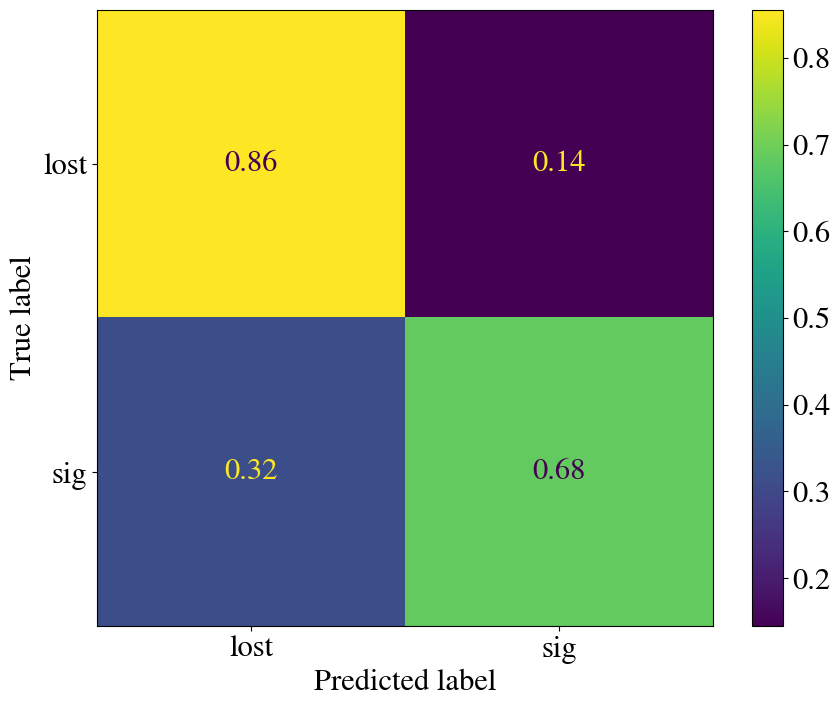

In [39]:
ptype_no_mu_e = ["lost", "sig"]
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ptype_no_mu_e)
disp.plot()
plt.show()

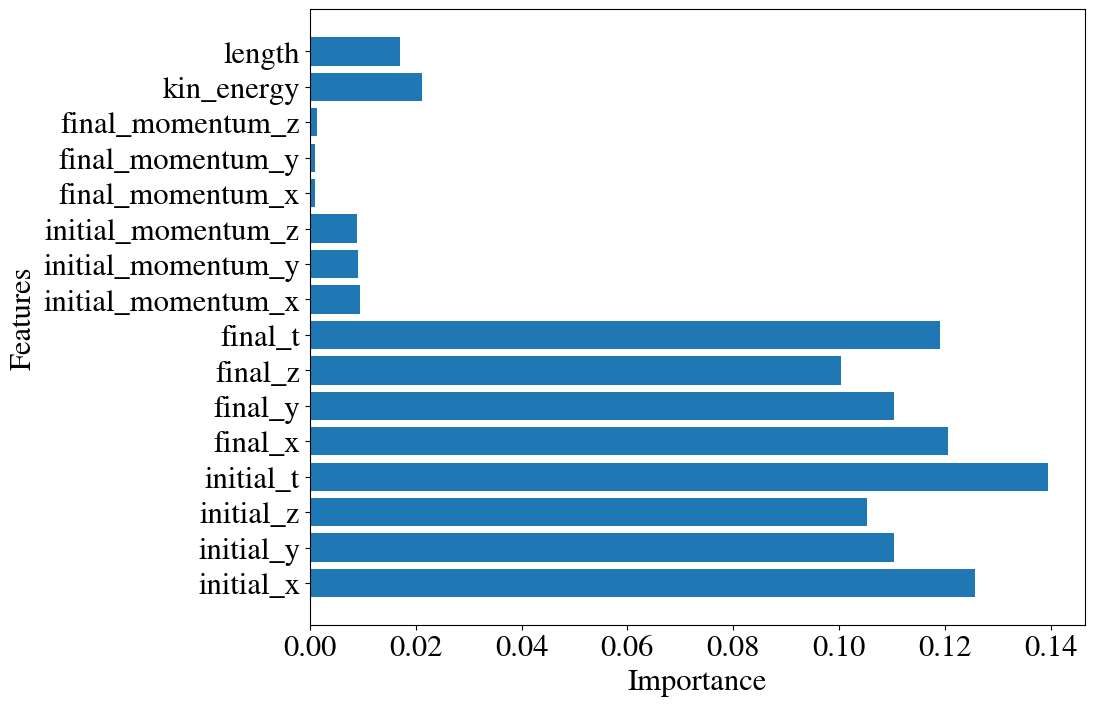

In [40]:
# PLot importance
importance = rf.feature_importances_
ytix = variable_list

plt.barh(range(16), importance)
plt.yticks(range(16), variable_list)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


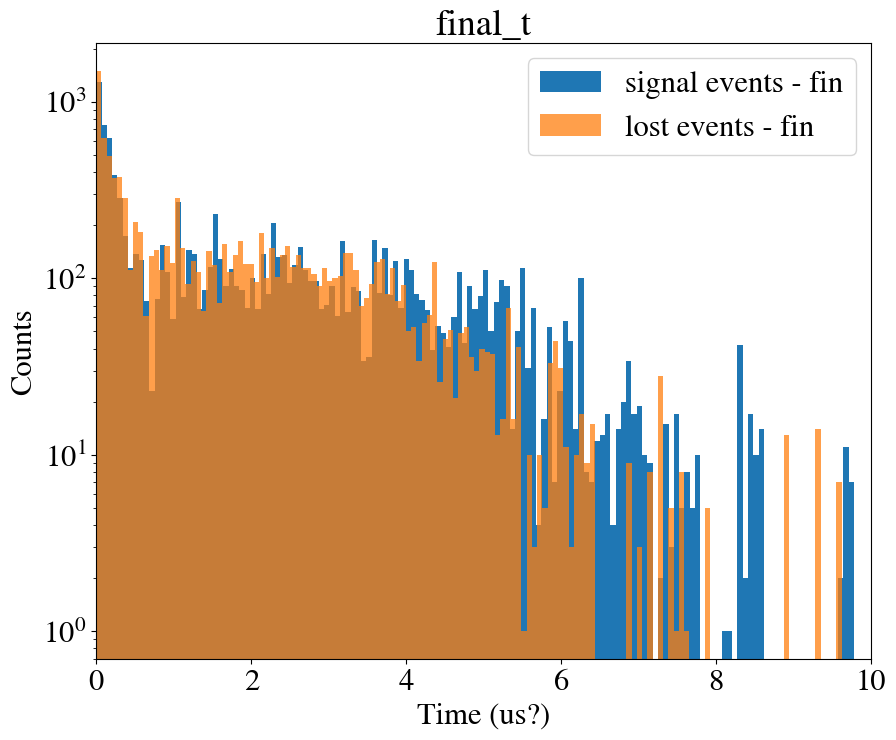

In [41]:
plt.hist(signal_df.final_t, bins = 1000, label = 'signal events - fin')
plt.hist(lost_df.final_t, bins = 1000, label = 'lost events - fin', alpha = 0.75)
plt.xlim([0,10])
plt.title("final_t")
plt.legend()
plt.yscale('log')
plt.ylabel("Counts")
plt.xlabel("Time (us?)")
plt.show()

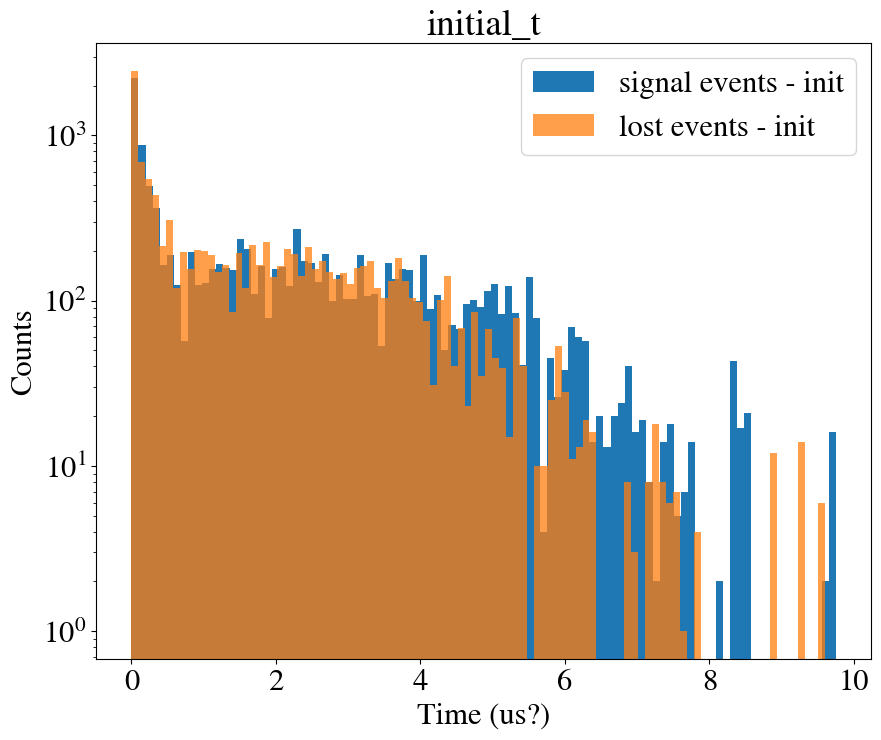

In [42]:

plt.hist(signal_df.initial_t, bins = 100, label = 'signal events - init')
plt.hist(lost_df.initial_t, bins = 100, label = 'lost events - init', alpha = 0.75)
plt.title("initial_t")
plt.legend()
plt.yscale('log')
plt.ylabel("Counts")
plt.xlabel("Time (us?)")
plt.show()

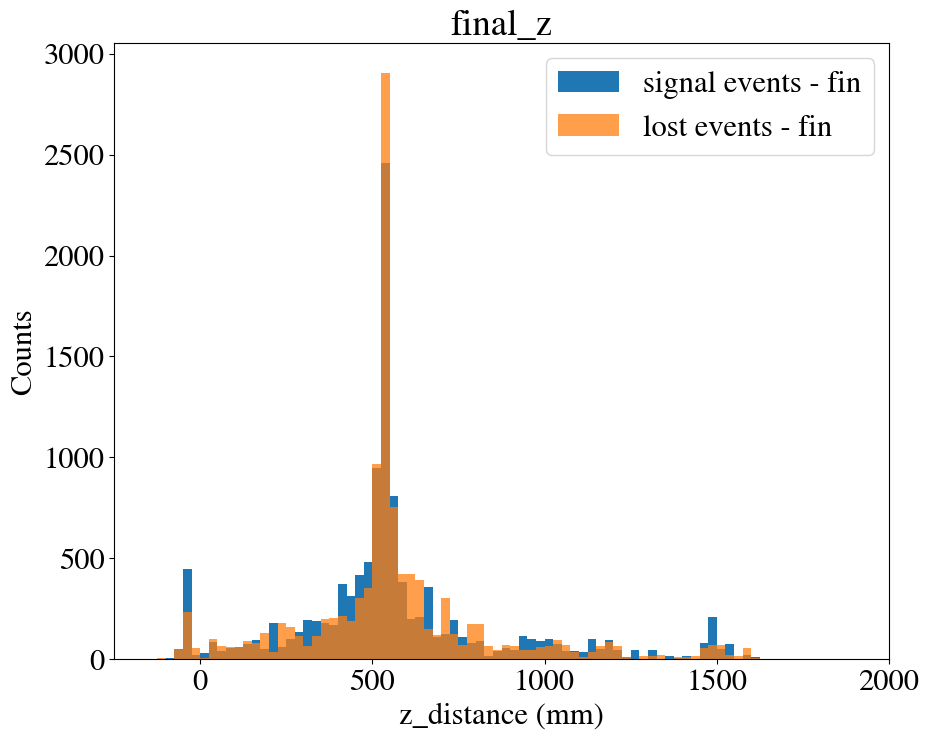

In [49]:
plt.hist(signal_df.final_z, bins = 1000, label = 'signal events - fin')
plt.hist(lost_df.final_z, bins = 1000, label = 'lost events - fin', alpha = 0.75)
plt.xlim([-250,2000])
plt.title("final_z")
plt.legend()
#plt.yscale('log')
plt.ylabel("Counts")
plt.xlabel("z_distance (mm)")
plt.show()

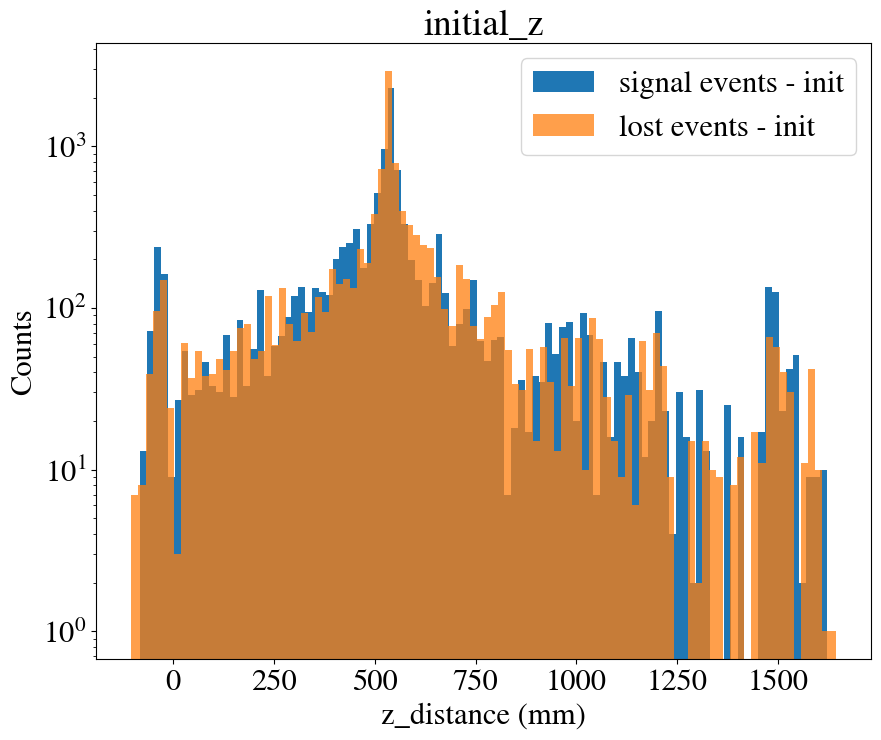

In [44]:
plt.hist(signal_df.initial_z, bins = 100, label = 'signal events - init')
plt.hist(lost_df.initial_z, bins = 100, label = 'lost events - init', alpha = 0.75)
#plt.xlim([0,10])
plt.title("initial_z")
plt.legend()
plt.yscale('log')
plt.ylabel("Counts")
plt.xlabel("z_distance (mm)")
plt.show()

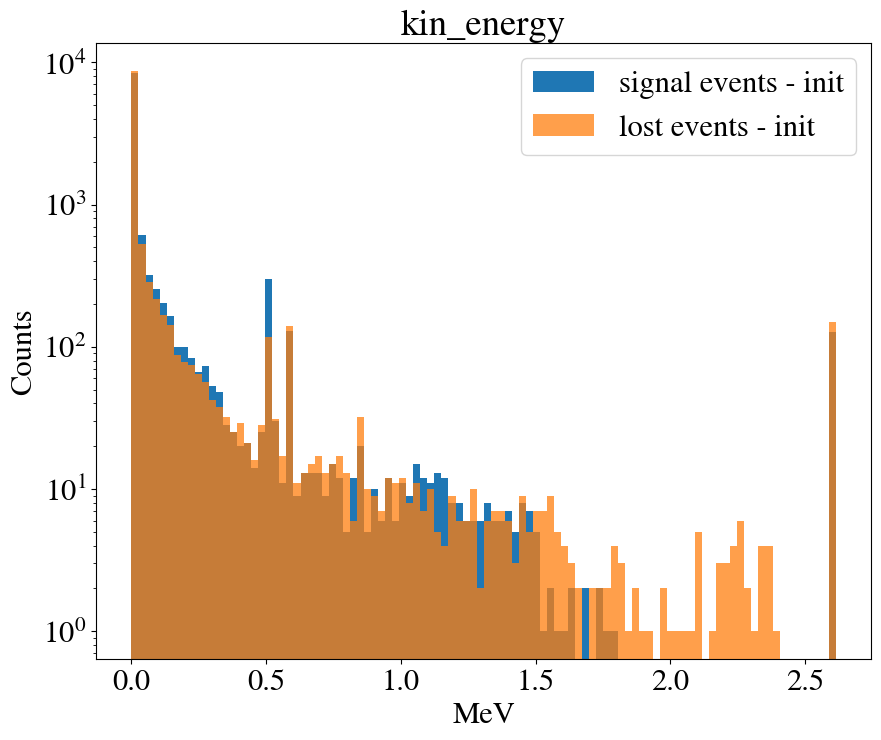

In [50]:
plt.hist(signal_df.kin_energy, bins = 100, label = 'signal events - init')
plt.hist(lost_df.kin_energy, bins = 100, label = 'lost events - init', alpha = 0.75)
#plt.xlim([0,10])
plt.title("kin_energy")
plt.legend()
plt.yscale('log')
plt.ylabel("Counts")
plt.xlabel("MeV")
plt.show()

In [45]:
#signal_df = collect_signal_events('testing_data/beersheba/', signals)
quick_df = collect_signal_events_MC('testing_data/beersheba/', MC_signals)


100%|██████████| 300/300 [00:38<00:00,  7.76it/s]


AttributeError: 'DataFrame' object has no attribute 'initial_z'

In [49]:
display(quick_df)
display(signal_df[signal_df.initial_z < 0])
display(quick_df[quick_df.event_id == 260103])

,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,260004,6,0,344.488708,344.087799,451.499634,0.371969,0.000140,ACTIVE
1,260004,14,0,344.488708,344.087799,451.499603,0.371974,0.000021,ACTIVE
2,260004,13,0,344.488770,344.087921,451.499664,0.372024,0.000023,ACTIVE
3,260004,12,0,344.488495,344.087830,451.499634,0.372022,0.000047,ACTIVE
4,260004,11,0,344.488739,344.087799,451.499664,0.371994,0.000023,ACTIVE
...,...,...,...,...,...,...,...,...,...
615712,1310161,41,10,37.945766,-3.660428,114.210838,2.303627,0.002448,ACTIVE
615713,1310161,41,11,37.944702,-3.662926,114.212708,2.303740,0.001599,ACTIVE
615714,1310161,41,12,37.945160,-3.662607,114.212029,2.303791,0.000834,ACTIVE
615715,1310161,27,0,38.261108,-4.199391,114.248291,2.296106,0.000016,ACTIVE


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,tag
142604,260103,15,e-,False,6,212.774765,287.387787,-39.552197,2.490300,212.774765,...,0.004058,-0.006402,-0.0,0.0,-0.0,0.000058,1.447787e-07,phot,msc,sig
142605,260103,14,e-,False,6,212.774765,287.387787,-39.552197,2.490300,212.774765,...,0.000877,0.000293,-0.0,0.0,0.0,0.000918,1.715748e-05,phot,eIoni,sig
142606,260103,13,e-,False,6,212.774765,287.387787,-39.552197,2.490300,212.774765,...,0.016249,-0.023886,-0.0,0.0,-0.0,0.000871,1.452411e-05,phot,eIoni,sig
142607,260103,12,e-,False,6,212.774765,287.387787,-39.552197,2.490300,212.774719,...,0.068392,0.024332,-0.0,0.0,-0.0,0.007047,2.663117e-04,phot,eIoni,sig
142608,260103,11,e-,False,6,212.774765,287.387787,-39.552197,2.490300,212.769806,...,-0.310266,-0.004681,0.0,0.0,-0.0,0.143656,4.662707e-02,phot,eIoni,sig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3712845,880143,48,e-,False,32,23.915476,521.575806,-53.289700,2.488853,23.914841,...,0.146134,0.190710,-0.0,0.0,0.0,0.059990,1.082238e-02,compt,eIoni,sig
3712846,880143,47,e-,False,32,22.766659,520.965088,-56.909191,2.476023,22.768808,...,0.524517,-0.812396,0.0,0.0,0.0,0.689329,4.770213e-01,compt,eIoni,sig
3712847,880143,46,e-,False,32,43.525070,491.659180,-32.164085,2.330547,43.506557,...,-0.337135,-0.534143,0.0,0.0,0.0,0.315380,1.624073e-01,compt,eIoni,sig
3759812,840067,30,e-,False,27,-434.038177,106.019409,-22.522345,3.544747,-436.008759,...,-1.062719,-0.704563,-0.0,0.0,0.0,1.551793,4.386665e+00,compt,eIoni,sig


,event_id,particle_id,hit_id,x,y,z,time,energy,label
3073,260103,17,0,312.628296,-324.224976,391.439972,3.071409,0.000246,ACTIVE
3074,260103,33,0,312.628265,-324.225006,391.439972,3.071414,0.000021,ACTIVE
3075,260103,32,0,312.628143,-324.225159,391.440033,3.071465,0.000045,ACTIVE
3076,260103,31,0,312.628204,-324.225159,391.440063,3.071482,0.000023,ACTIVE
3077,260103,30,0,312.628326,-324.224976,391.439972,3.071419,0.000047,ACTIVE
...,...,...,...,...,...,...,...,...,...
3241,260103,42,7,310.833801,-325.308594,392.770905,3.084845,0.001113,ACTIVE
3242,260103,42,8,310.838654,-325.299500,392.771271,3.085081,0.001790,ACTIVE
3243,260103,42,9,310.833801,-325.299561,392.774719,3.085246,0.001452,ACTIVE
3244,260103,42,10,310.832825,-325.296906,392.775787,3.085353,0.000387,ACTIVE


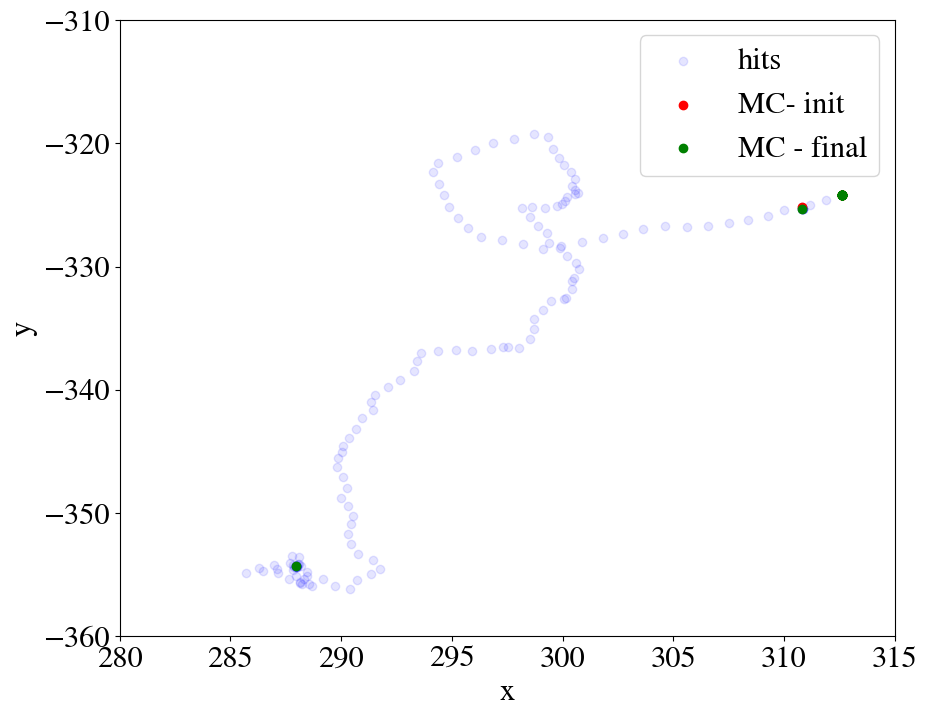

In [64]:
sdf = signal_df[signal_df.event_id == 260103]
qdf = (quick_df[quick_df.event_id == 260103])
plt.scatter(qdf.x, qdf.y, color = 'blue', alpha = 0.1, label = 'hits')
plt.scatter(sdf.initial_x, sdf.initial_y, color = 'red', alpha = 1, label = 'MC- init')
plt.scatter(sdf.final_x, sdf.final_y, color = 'green', alpha = 1, label = 'MC - final')


plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([280,315])
plt.ylim([-360,-310])
plt.show()


In [71]:
# quick check
display(signal_df[signal_df.event_id == 260103])

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,tag
142599,260103,1,Tl208,True,0,392.838470,396.394073,534.153748,0.000000,392.838470,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,none,RadioactiveDecay,sig
142600,260103,4,e-,False,1,392.838470,396.394073,534.153748,0.000372,392.883728,...,-0.665296,1.062304,-0.000000,-0.000000,-0.000000,8.555868e-01,9.168316e-01,RadioactiveDecay,eIoni,sig
142601,260103,3,anti_nu_e,False,1,392.838470,396.394073,534.153748,0.000372,5294.602051,...,0.718505,0.541472,0.290983,0.718505,0.541472,9.455749e-01,1.592873e+04,RadioactiveDecay,Transportation,sig
142602,260103,2,Pb208[3197.711],False,1,392.838470,396.394073,534.153748,0.000372,392.838470,...,-0.053209,-1.603775,-0.000000,-0.000000,-0.000000,7.239141e-06,0.000000e+00,RadioactiveDecay,RadioactiveDecay,sig
142603,260103,6,gamma,False,2,392.838470,396.394073,534.153748,0.000372,212.774765,...,-0.053792,0.499185,-0.000000,-0.000000,-0.000000,5.831881e-01,7.464616e+02,RadioactiveDecay,phot,sig
142604,260103,15,e-,False,6,212.774765,287.387787,-39.552197,2.490300,212.774765,...,0.004058,-0.006402,-0.000000,0.000000,-0.000000,5.797000e-05,1.447787e-07,phot,msc,sig
142605,260103,14,e-,False,6,212.774765,287.387787,-39.552197,2.490300,212.774765,...,0.000877,0.000293,-0.000000,0.000000,0.000000,9.176000e-04,1.715748e-05,phot,eIoni,sig
142606,260103,13,e-,False,6,212.774765,287.387787,-39.552197,2.490300,212.774765,...,0.016249,-0.023886,-0.000000,0.000000,-0.000000,8.705800e-04,1.452411e-05,phot,eIoni,sig
142607,260103,12,e-,False,6,212.774765,287.387787,-39.552197,2.490300,212.774719,...,0.068392,0.024332,-0.000000,0.000000,-0.000000,7.047180e-03,2.663117e-04,phot,eIoni,sig
142608,260103,11,e-,False,6,212.774765,287.387787,-39.552197,2.490300,212.769806,...,-0.310266,-0.004681,0.000000,0.000000,-0.000000,1.436556e-01,4.662707e-02,phot,eIoni,sig


so the MC hits and true info works as expected. 

Does the MC energy reflect the total energy from the hits?

In [66]:
# MC
hits_total_E = []
hits_event_IDs = []
MC_total_E = []
MC_event_IDs = []
for event, df in quick_df.groupby("event_id"):
    print("Event: {}\n Total energy: {} MeV".format(event, df.energy.sum()))
    hits_total_E.append(df.energy.sum())
    hits_event_IDs.append(event)

for event, df in signal_df.groupby("event_id"):
    print("Event: {}\n Total energy: {} MeV".format(event, df.energy.sum()))
    MC_total_E.append(df.energy.sum())
    MC_event_IDs.append(event)

Event: 4
 Total energy: 1.1838266849517822 MeV
Event: 13
 Total energy: 0.48306402564048767 MeV
Event: 38
 Total energy: 0.40559831261634827 MeV
Event: 40
 Total energy: 0.7767629027366638 MeV
Event: 44
 Total energy: 0.511914074420929 MeV
Event: 57
 Total energy: 0.5463056564331055 MeV
Event: 70
 Total energy: 0.4099903702735901 MeV
Event: 78
 Total energy: 2.614504337310791 MeV
Event: 84
 Total energy: 0.44807446002960205 MeV
Event: 85
 Total energy: 1.4931983947753906 MeV
Event: 90
 Total energy: 0.41567885875701904 MeV
Event: 91
 Total energy: 0.5775917768478394 MeV
Event: 107
 Total energy: 0.8341292142868042 MeV
Event: 121
 Total energy: 0.4872475266456604 MeV
Event: 123
 Total energy: 0.7326536178588867 MeV
Event: 129
 Total energy: 0.7323372960090637 MeV
Event: 145
 Total energy: 0.4210582971572876 MeV
Event: 10025
 Total energy: 0.717199444770813 MeV
Event: 10029
 Total energy: 0.40143901109695435 MeV
Event: 10037
 Total energy: 0.4367389380931854 MeV
Event: 10076
 Total energ

AttributeError: 'DataFrame' object has no attribute 'energy'